In [11]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2.14.0


In [4]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-02-13 23:53:24.923833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 23:53:24.978595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 23:53:24.978740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Datos

In [5]:
## Function to get contours and features
def get_contours_and_features(binary_map):
    # get binary map
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    # get contours from binary map
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # get features from contours
    contours_features = []
    for contour in contours:
        error = 1e-5

        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        features = {
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features    
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    atributes = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)        

        ## obtener área de poros##
        area = np.ceil(np.sum(get_item(contour_features, key='area')))

        ## obtener perímetro de poros
        perimetro = np.ceil(np.sum(get_item(contour_features, key='perimeter'))
)
        ## intersticio
        area_total = np.ceil(np.shape(image)[0] * np.shape(image)[1])
        intersticio = np.ceil(area_total - area)

        ## Cantidad de poros
        poros = np.shape(contour_features)[0]

        #atributes = [area,perimetro,intersticio,poros]
        atributes.append([area,perimetro,intersticio,poros])
    
    return atributes

# function to associate geometric atributes with images

def normalize_geometric_properties(dataset):

    ## Listas para guardar propiedades
    areas = []
    perimetros = []
    intersticios = []
    poros = []

    for i in range(len(dataset)):    
        
        ## obtener ruta de la imagen
        mask_route = dataset['route_mask'].to_numpy()[i]
        ## obtener imagen binaria
        mask = get_binary_image([mask_route])
        ## capturar propiedades
        atrs = get_geometric_atributes(mask)[0]

        ## agregar a listas las propiedades
        areas.append(atrs[0])
        perimetros.append(atrs[1])
        intersticios.append(atrs[2])
        poros.append(atrs[3])
        
    
    ## Crear dataset con propiedades
    dataset_prop = dataset.copy()
    dataset_prop['area'] = areas
    dataset_prop['perimetro'] = perimetros
    dataset_prop['intersticio'] = intersticios
    dataset_prop['poros'] = poros

    ## normalizar datos
        
    # normalizar area
    min_area = np.min(areas)
    max_area = np.max(areas)
    areas_norm = (areas - min_area) / (max_area - min_area)

    # normailizar perimetro
    min_perimetro = np.min(perimetros)
    max_perimetro = np.max(perimetros)
    perimetros_norm = (perimetros - min_perimetro) / (max_perimetro - min_perimetro)

    #normalizar intersticio
    min_intersticio = np.min(intersticios)
    max_intersticio = np.max(intersticios)
    intersticios_norm = (intersticios - min_intersticio) / (max_intersticio - min_intersticio)

    #normalizar poros
    min_poros = np.min(poros)
    max_poros = np.max(poros)
    poros_norm = (poros - min_poros) / (max_poros - min_poros)

    ## agregar propiedades normalizadas al dataset
    dataset_norm = dataset.copy()
    dataset_norm['area'] = areas_norm
    dataset_norm['perimetro'] = perimetros_norm
    dataset_norm['intersticio'] = intersticios_norm
    dataset_norm['poros'] = poros_norm


    return dataset_prop, dataset_norm, [min_area, min_perimetro, min_intersticio, min_poros], [max_area, max_perimetro, max_intersticio, max_poros]


## desnormalizar datos
def de_normalize_value(value, min_value, max_value):
    return (value * (max_value - min_value)) + min_value

## Reorganizar atributos geométricos
def organize_geometric_atributes(dataset):
    attributes = []
    for i in range(len(dataset)):
        attributes.append([dataset['area'].to_numpy()[i],dataset['perimetro'].to_numpy()[i],dataset['intersticio'].to_numpy()[i],dataset['poros'].to_numpy()[i]])

    return attributes

def split_dataset(routes_dataset):
    ## Establecer el porcentaje de separación
    thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
    thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
    thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

    ## Separar por clases para entrenamiento
    train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
    train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
    train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

    ## tomar las demás imágenes para test
    test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
    test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
    test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


    ## Constuir un solo dataset de training
    train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

    ## Construir un solo dataset de test
    test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

    ## Cantidad de muestras por clase
    print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
    print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
    print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

    return train_df, test_df


def create_dataset(buffer,dataset): 
  ## Get file names
  file_names = dataset['route_image'].to_numpy()
  ## Get labels
  labels = dataset['label'].to_numpy()
  ## Get geometric atributes from binary images
  attributes = organize_geometric_atributes(dataset)
  ## Create dataset from tensors assosiated with labels and attributes
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes))
  ## Shuffle dataset
  dataset.shuffle(buffer_size=buffer)
  ## Map dataset to load images (a = image, b = label, c = attributes, d = mask)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes))

  return dataset

In [6]:
## Obtener todas las rutas de las imágenes en el dataset
ruta = '../Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg'
rutas_dataset  = glob.glob('../../../Datasets/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[6]
    number = ruta_list[7]
    tipo = ruta_list[8]
    name = ruta_list[9].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', np.shape(routes_dataset[routes_dataset['label']=='MF1'])[0])
print('MF2:', np.shape(routes_dataset[routes_dataset['label']=='MF2'])[0])
print('MF3:', np.shape(routes_dataset[routes_dataset['label']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['label'].replace(char_to_num,inplace=True)

dataset, dataset_norm, mins, maxs = normalize_geometric_properties(routes_dataset)

train_df, test_df = split_dataset(dataset)

dataset = create_dataset(16,train_df)

Imágenes secas: 923
MF1: 378
MF2: 284
MF3: 261


2024-02-13 23:53:26.387660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 23:53:26.387869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 23:53:26.388012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Clase MF1: train:  303 , test:  75
Clase MF2: train:  228 , test:  56
Clase MF3: train:  209 , test:  52


[6634. 1948. 9750.   33.]
b'0'


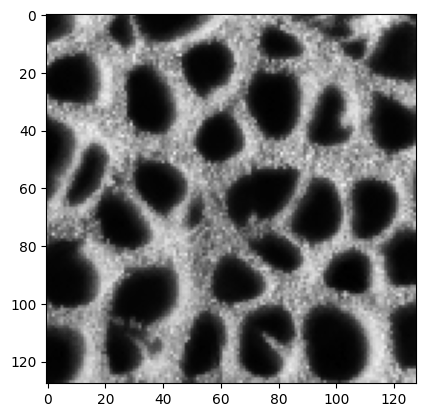

In [7]:
cnt = 0
for i in dataset.batch(16):
    a = i[0]
    b = i[1]
    c = i[2]    

n =  0
print(c[n].numpy())
print(b[n].numpy())
plt.imshow(a[n],cmap='gray')
plt.show()

In [8]:
## Dataset de prueba
test_df = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_secas = []
y_test_secas = []
pore_area_test = []
pore_perimeter_test = []
pore_interstice_test = []
pore_number_test = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df)):
    
    #Capturar ruta y label
    ruta = test_df.iloc[i].route_image
    label = test_df.iloc[i].label
    area = test_df.iloc[i].area
    perimetro = test_df.iloc[i].perimetro
    intersticio = test_df.iloc[i].intersticio
    poros = test_df.iloc[i].poros
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta,color_mode='grayscale')
    
    X_test_secas.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_secas.append(test_df.iloc[i].label)
    pore_area_test.append(area)
    pore_perimeter_test.append(perimetro)
    pore_interstice_test.append(intersticio)
    pore_number_test.append(poros)
    
print('Imágenes secas:',len(X_test_secas))
print('MF1:',np.sum(np.array(y_test_secas)=='0'))
print('MF2:',np.sum(np.array(y_test_secas)=='1'))
print('MF3:',np.sum(np.array(y_test_secas)=='2'))
print('número de etiquetas:',len(y_test_secas))
print('Numero de etiquetas de area poros:',len(pore_area_test))
print('Numero de etiquetas de perimetro poros:',len(pore_perimeter_test))
print('Numero de etiquetas de intersticio:',len(pore_interstice_test))
print('Numero de etiquetas de numero de poros:',len(pore_number_test))

Imágenes secas: 183
MF1: 75
MF2: 56
MF3: 52
número de etiquetas: 183
Numero de etiquetas de area poros: 183
Numero de etiquetas de perimetro poros: 183
Numero de etiquetas de intersticio: 183
Numero de etiquetas de numero de poros: 183


In [9]:
x_test_secas = np.array(X_test_secas)
x_test_secas= x_test_secas.astype('float32')
 
#y_test_secas = tf.keras.utils.to_categorical(y_test_secas)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_secas /= 255

print('Number of images in x_test', x_test_secas.shape, "y_test: ", np.shape(y_test_secas))

Number of images in x_test (183, 128, 128, 1) y_test:  (183,)


In [10]:
x_train = []
y_train_ten = []
for data,label,attributes in dataset.batch(8):
    x_train.extend(data[:].numpy())
    y_train_ten.extend(label)   

x_train = np.array(x_train)
x_train = x_train.astype('float32')

y_train= []
for i in y_train_ten:
    y_train.append(str(int(i)))

print(np.shape(x_train),np.shape(y_train))

(740, 128, 128, 1) (740,)


# Modelo

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
encoder = keras.models.load_model('Models/weakly2_GVAE_encoder_DRY_1_32.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('Models/weakly2_GVAE_decoder_DRY_1_32.h5', custom_objects={'Sampling':Sampling})

2024-02-13 23:54:36.707111: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


# Properties over latent space

## Generar embebidos

In [13]:
## Media = 0, Varianza = 1, Z = 2
D = 2

## Dimensiones
dmx = 8
dmy = 4

In [14]:
## Data train and test
data_train = x_train
data_test = x_test_secas

## Labels
label_train = y_train
label_test = y_test_secas

print('Train: ',np.shape(data_train),np.shape(label_train))
print('Test: ',np.shape(data_test),np.shape(label_test))

# Embebidos del encoder
encoder_embds  = encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

Train:  (740, 128, 128, 1) (740,)
Test:  (183, 128, 128, 1) (183,)


2024-02-13 23:54:37.026682: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48496640 exceeds 10% of free system memory.
2024-02-13 23:54:37.102197: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48496640 exceeds 10% of free system memory.
2024-02-13 23:54:37.564380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-02-13 23:54:38.194183: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-13 23:54:38.195516: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available

24/24 [==============================] - 4s 85ms/step
Shape_embs:  (3, 740, 32)
6/6 [==============================] - 1s 239ms/step
Shape_embs:  (3, 183, 32)


### PCA

In [15]:
pca_data_test = PCA(n_components=2)
PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test[D])
PCA_2dim_test.shape

(183, 2)

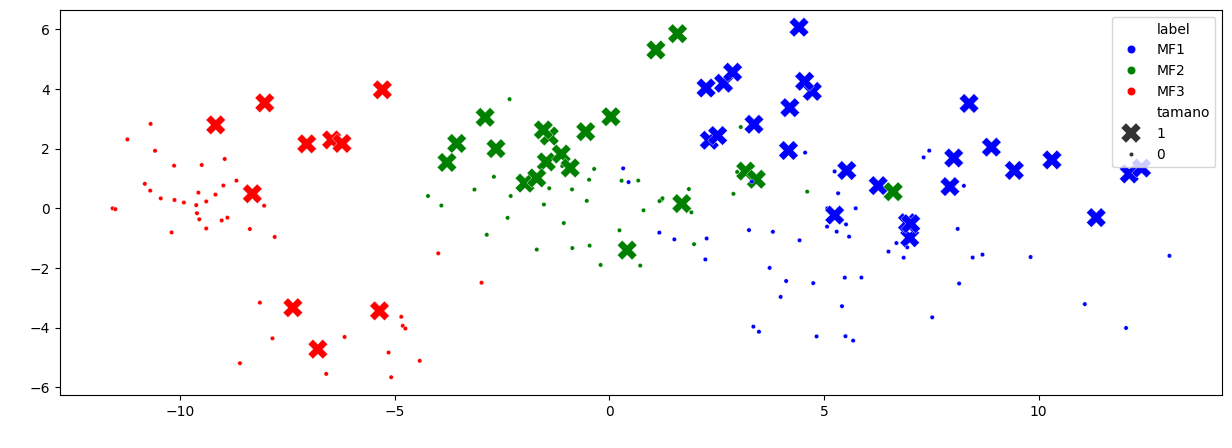

In [16]:
## graph pca embbedings regarding labels
labels_text_test = pd.DataFrame(label_test).replace({'0': "MF1", '1': "MF2",'2': "MF3"})
labels_text_test.shape

data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)
data_img_pca_test['area'] = pore_area_test
data_img_pca_test['perimetro'] = pore_perimeter_test
data_img_pca_test['intersticio'] = pore_interstice_test
data_img_pca_test['poros'] = pore_number_test
data_img_pca_test['tamano'] = data_img_pca_test['area'].apply(lambda x: 1 if x > 6500 else 0)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,
                style='tamano',
                alpha=1, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True, size='tamano',sizes=(10, 200),size_order=[1,0])
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

In [17]:
data_img_pca_test

,x,y,label,area,perimetro,intersticio,poros,tamano
0,0.324433,1.338556,MF1,5951.0,1838.0,10433.0,37,0
1,8.465210,-1.652935,MF1,6205.0,1566.0,10179.0,20,0
2,-2.293657,0.410811,MF2,6337.0,2311.0,10047.0,48,0
3,-11.564906,-0.002127,MF3,6333.0,3098.0,10051.0,85,0
4,3.811719,-0.789316,MF1,6023.0,1763.0,10361.0,31,0
...,...,...,...,...,...,...,...,...
178,-4.747783,-4.033402,MF3,5700.0,2772.0,10684.0,78,0
179,-8.681937,0.925253,MF3,5786.0,2880.0,10598.0,87,0
180,4.550896,4.257529,MF1,6752.0,1822.0,9632.0,32,1
181,-1.687304,1.016151,MF2,7017.0,2515.0,9367.0,49,1


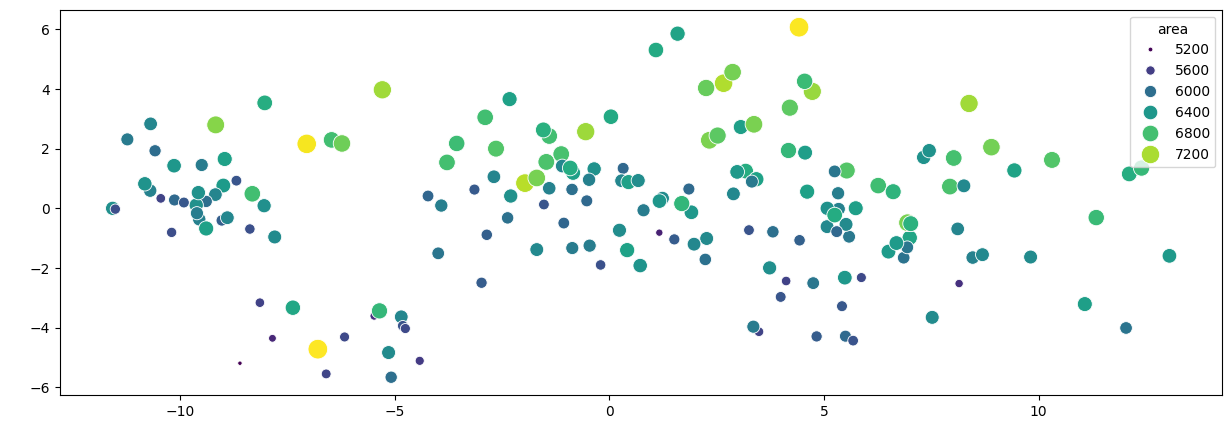

In [18]:
## graph pca embeddings regarding pore area
import matplotlib.cm as cm
sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='area',data=data_img_pca_test, 
                alpha=1, palette= "viridis",size='area',sizes=(10, 200),size_order=[1,0])

## Set colobar
#data_color = pore_area_test
#min = np.min(data_color)
#max = np.max(data_color)
#plt.colorbar(cm.ScalarMappable(cmap=plt.jet()),label='Pore area',orientation='vertical', ax=plt.gca())

plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()


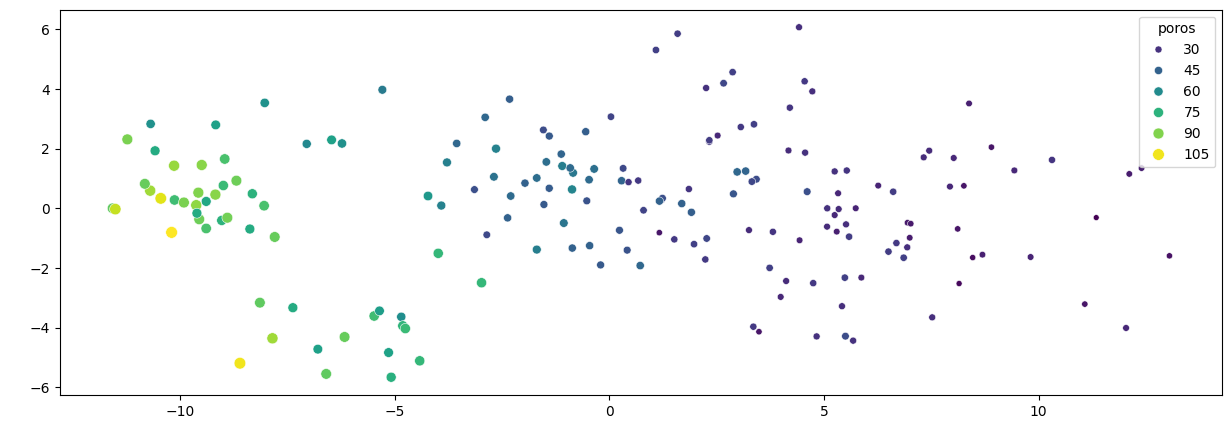

In [19]:
## graph pca embeddings regarding pore area
import matplotlib.cm as cm
sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='poros',data=data_img_pca_test, 
                alpha=1, palette="viridis",size='poros')


plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

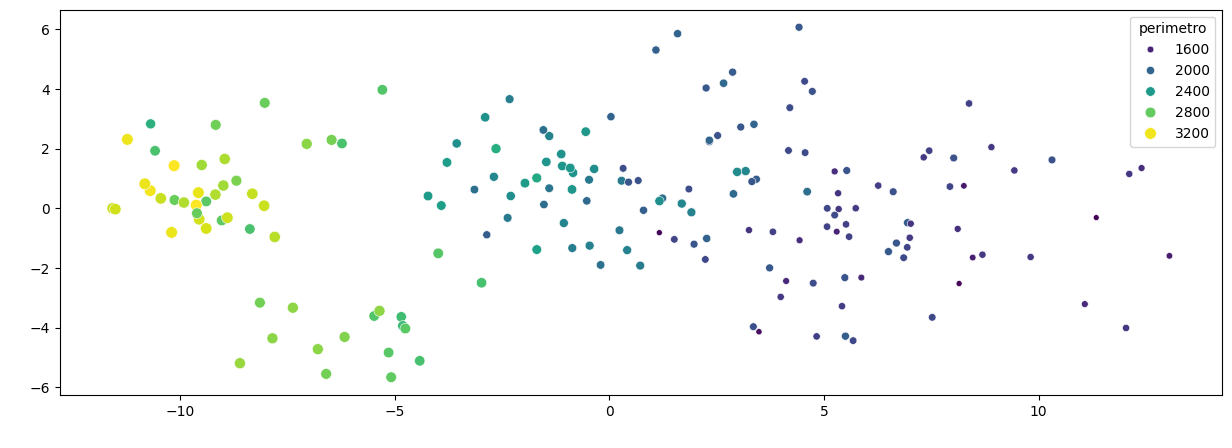

In [20]:
## graph pca embeddings regarding pore area
import matplotlib.cm as cm
sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='perimetro',data=data_img_pca_test, 
                alpha=1, palette="viridis",size='perimetro')


plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

## Clustering por propiedades

In [21]:
np.shape(encoder_embds_test[2][:][:])

(183, 32)

In [22]:
np.shape(PCA_2dim_test[:,0])

(183,)

In [23]:
data_properties = pd.DataFrame()
data_properties['x'] = PCA_2dim_test[:,0]
data_properties['y'] = PCA_2dim_test[:,1]
data_properties['label'] = labels_text_test
data_properties['area'] = pore_area_test
data_properties['perimetro'] = pore_perimeter_test
data_properties['intersticio'] = pore_interstice_test
data_properties['poros'] = pore_number_test
data_properties

,x,y,label,area,perimetro,intersticio,poros
0,0.324433,1.338556,MF1,5951.0,1838.0,10433.0,37
1,8.465210,-1.652935,MF1,6205.0,1566.0,10179.0,20
2,-2.293657,0.410811,MF2,6337.0,2311.0,10047.0,48
3,-11.564906,-0.002127,MF3,6333.0,3098.0,10051.0,85
4,3.811719,-0.789316,MF1,6023.0,1763.0,10361.0,31
...,...,...,...,...,...,...,...
178,-4.747783,-4.033402,MF3,5700.0,2772.0,10684.0,78
179,-8.681937,0.925253,MF3,5786.0,2880.0,10598.0,87
180,4.550896,4.257529,MF1,6752.0,1822.0,9632.0,32
181,-1.687304,1.016151,MF2,7017.0,2515.0,9367.0,49


In [26]:
## Area de poro
## dividir en 3 valores: pequeño, normal, grande

# 1. Calcular límite inferior y superior para el área de poro
valores = data_properties['area'].to_numpy()
min_area = np.mean(valores) - np.std(valores)
max_area = np.mean(valores) + np.std(valores)

# 2. crear un dataframe solo con area de poros
data_area = pd.DataFrame()
data_area['x'] = PCA_2dim_test[:,0]
data_area['y'] = PCA_2dim_test[:,1]
data_area['label'] = labels_text_test
data_area['area'] = pore_area_test


# 2.crear un dataframe que los cataloguqe en pequeño, normal y grande
data_area['tamano'] = data_area['area'].apply(lambda x: 2 if x > max_area else 0 if x < min_area else 1)

data_area

,x,y,label,area,tamano
0,0.324433,1.338556,MF1,5951.0,1
1,8.465210,-1.652935,MF1,6205.0,1
2,-2.293657,0.410811,MF2,6337.0,1
3,-11.564906,-0.002127,MF3,6333.0,1
4,3.811719,-0.789316,MF1,6023.0,1
...,...,...,...,...,...
178,-4.747783,-4.033402,MF3,5700.0,0
179,-8.681937,0.925253,MF3,5786.0,0
180,4.550896,4.257529,MF1,6752.0,1
181,-1.687304,1.016151,MF2,7017.0,2
